In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from consolidated_runs import run_simulations

from Pearson.pearson import Pearson

sys.path.append(os.getcwd())

In [3]:
import random

def sample_with_proportion(total, targets, proportion):
    total_sample = 10
    num_special = int(total_sample * proportion)
    special = np.random.choice(targets, num_special, replace=False)

    remaining = list(set(total) - set(targets))
    normal = np.random.choice(remaining, total_sample - num_special, replace=False)

    final = np.concatenate([special, normal])
    np.random.shuffle(final)
    return final

In [4]:
# datasets = range(1, 4) # DS3
# run_simulations(datasets,
#             sergio=True,
#             saucie=True, 
#             scScope=True, 
#             deepImpute=True, 
#             magic=True, 
#             genie=False,
#             arboreto=False,
#             pearson=False,
#             roc=False,
#             precision_recall_k=False
#         )

In [5]:
imp_dir = os.path.join(os.getcwd(), 'imputations')
print(imp_dir)
for i in range(1, 4):
    load_dir = os.path.join(imp_dir, f'DS{i}')
    save_name = 'DS6_expr.npy'

    expr = np.load(os.path.join(load_dir, save_name))
    print(expr.shape)
    file_name = 'expr_shape.csv'
    if not os.path.exists(os.path.join(load_dir, file_name)):
        npfile = np.load(os.path.join(load_dir, save_name))
        shap = npfile.shape
        print(shap)
        df = pd.DataFrame([shap])
        df.to_csv(load_dir + '/' + file_name, index=False)

/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations
(9, 100, 300)
(9, 100, 300)
(9, 400, 300)
(9, 400, 300)
(9, 1200, 300)
(9, 1200, 300)


In [6]:
imp_dir = os.path.join(os.getcwd(), 'imputations')

def run_pearson_ranking(proportion):
    print("Running Pearson ranking tests with proportion", proportion)
    for i in range(1, 4):
        gt_file = None
        if i == 1:
            gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        elif i == 2:
            gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        elif i == 3:
            gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        
        # For now, just load clean data, save as csv, and load it back in
        methods = ['Clean', 'Noisy', 'SAUCIE', 'scScope', 'DeepImpute', 'MAGIC']
        file_name = ''
        save_name = ''
        for method in methods:
            if method == 'Clean':
                file_name = f'DS6_clean.npy'
                save_name = f'DS6_clean.csv'
            elif method == 'Noisy':
                file_name = f'DS6_45.npy'
                save_name = f'DS6_45.csv'
            elif method == 'SAUCIE':
                file_name = f'yhat_SAUCIE.npy'
                save_name = f'yhat_SAUCIE.csv'
            elif method == 'scScope':
                file_name = f'yhat_scScope.npy'
                save_name = f'yhat_scScope.csv'
            elif method == 'DeepImpute':
                file_name = f'yhat_deepImpute.npy'
                save_name = f'yhat_deepImpute.csv'
            elif method == 'MAGIC':
                file_name = f'yhat_MAGIC_t_auto.npy'
                save_name = f'yhat_MAGIC_t_auto.csv'
            load_dir = os.path.join(imp_dir, f'DS{i}')
            if not os.path.exists(os.path.join(imp_dir, f'DS{i}', save_name)):
                npfile = np.load(load_dir + '/' + file_name)
                df = pd.DataFrame(npfile)
                df.to_csv(load_dir + '/' + save_name, index=False)
            clean_df = pd.read_csv(os.path.join(load_dir, save_name))
            
            # Read ground truth
            gt = pd.read_csv(gt_file, header=None)
            confirmed_genes = gt[0].unique()

            # Run Pearson on clean and noisy data
            pearson = Pearson(np.transpose(clean_df), '')
            p_values = pearson.values
            np.fill_diagonal(p_values, 0)
            pearson = pd.DataFrame(p_values, index=pearson.columns, columns=pearson.columns)

            total = 0
            for r in range(50):
                sampled = sample_with_proportion(clean_df.index.tolist(), confirmed_genes, proportion)
            # Take subset of pearson data with only the sampled genes
                p_subset = pearson.loc[sampled]
            #print(p_subset)
            # Rank the expression pairs by the absolute value of the pearson correlation
                melted = pd.melt(p_subset.reset_index(), id_vars=['index'], value_vars=p_subset.columns)
                melted.columns = ['input', 'target', 'correlation']
                melted_sorted = melted.sort_values(by='correlation', ascending=False)
                ranked_list = list(melted_sorted.itertuples(index=False, name=None))[:10]
            # Calculate the proportion of confirmed genes in the top k of the ranked pairs
                top_10 = [(input, target) for input, target, _ in ranked_list]
                true_pairs = set(tuple(x) for x in gt.values)
                matches = sum(1 for pair in top_10 if pair in true_pairs)
                prop = matches / len(top_10)
                total += prop

            print(f"DS{i}", method, total / 50)

In [7]:
# run_pearson_ranking(0.1)
# run_pearson_ranking(0.2)
# run_pearson_ranking(0.3)

In [8]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import random

def run_pearson_edge_sampling(proportion):
    print("Running Pearson edge sampling tests with proportion", proportion)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    
    for i in range(1, 4):
        if i == 1:
            gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        elif i == 2:
            gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        elif i == 3:
            gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        
        methods = ['Clean', 'Noisy', 'SAUCIE', 'scScope', 'DeepImpute', 'MAGIC']
        
        for method in methods:
            file_name = f'DS{i}_{method}.csv'  # Adjusted for simplicity
            load_dir = os.path.join(imp_dir, f'DS{i}')
            data_file_path = os.path.join(load_dir, file_name)

            if not os.path.exists(data_file_path):
                print(f"File {data_file_path} does not exist. Skipping.")
                continue
            
            clean_df = pd.read_csv(data_file_path)
            gt = pd.read_csv(gt_file, header=None)
            
            confirmed_edges = set(tuple(x) for x in gt.values)
            
            all_possible_edges = [(row, col) for row in clean_df.columns for col in clean_df.columns if row != col]
            num_edges_to_sample = int(len(all_possible_edges) * proportion)
            
            total = 0
            for r in range(50):
                sampled_edges = random.sample(all_possible_edges, num_edges_to_sample)
                matches = 0
                for edge in sampled_edges:
                    gene1, gene2 = edge
                    corr, _ = pearsonr(clean_df[gene1], clean_df[gene2])
                    # Check if this edge is in the confirmed edges and if the correlation is significant
                    if edge in confirmed_edges and abs(corr) > 0.5:  # Threshold for "significant" correlation can be adjusted
                        matches += 1
                prop = matches / len(sampled_edges)
                total += prop
            
            print(f"DS{i} {method}: Proportion of significant confirmed edges = {total / 50}")

# Example usage
proportion = 0.1
run_pearson_edge_sampling(proportion)


Running Pearson edge sampling tests with proportion 0.1
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_Clean.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_Noisy.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_SAUCIE.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_scScope.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_DeepImpute.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_MAGIC.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS2/DS2_Clean.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS2/

In [11]:
from parallel_utils import process_iteration
from time import time
import concurrent
from concurrent.futures import ProcessPoolExecutor

def edge_finding_experiment(dataset_id, last_iteration=0, fixed_edge=False):
    print("Running edge finding experiment")
    gt_file = None
    if dataset_id == 1:
        gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt'
        regs_path = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt'
    elif dataset_id == 2:
        gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Interaction_cID_5.txt'
        regs_path = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Regs_cID_5.txt'
    elif dataset_id == 3:
        gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt'
        regs_path = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt'
        
    reg_df = pd.read_csv(regs_path, header=None)
    master_regs = [int(m) for m in reg_df[0].values]
    true_pearson = pd.DataFrame()
    gt = pd.read_csv(gt_file, header=None)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    load_dir = os.path.join(imp_dir, f'DS{dataset_id}')
    ranks = []
    correlations = []

    # check if experiment file exists for this dataset
    experiment_dir = os.path.join(os.getcwd(), 'experiments/edge_finding/')
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_edge_finding_experiment.csv")
    if fixed_edge:
        experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_edge_finding_experiment_fixed_edge.csv")
    if os.path.exists(experiment_file) and last_iteration != 0:
        df = pd.read_csv(experiment_file)
        ranks = df['Rank'].values.tolist()
        correlations = df['Correlation'].values.tolist()  
    
    fixed_chosen_pair = None
    
    with ProcessPoolExecutor(max_workers=4) as executor:
        futures = []
        for iteration in tqdm(range(last_iteration, 51)):
            file_extension = ''
            if iteration == 0:
                #run_sergio(target_file, regs_path, i, file_extension)
                clean_df = pd.DataFrame(np.load(os.path.join(load_dir, f"DS6_clean{file_extension}.npy")))
                true_pearson = Pearson(np.transpose(clean_df), '')
                p_values = true_pearson.values
                np.fill_diagonal(p_values, 0)
                true_pearson = pd.DataFrame(p_values, index=true_pearson.columns, columns=true_pearson.columns)
            else:
                file_extension = f'_iter{iteration}'
                futures.append(executor.submit(process_iteration, iteration, target_file, regs_path, master_regs, load_dir, imp_dir, dataset_id, file_extension))
        iter = 0
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            pearson, chosen_pair, temp_target, f_ext = future.result()
            if fixed_edge and iter == 0:
                fixed_chosen_pair = chosen_pair
            elif fixed_edge:
                while fixed_chosen_pair is None:
                    time.sleep(0.1)
                chosen_pair = fixed_chosen_pair
            regulator_row = pearson.loc[chosen_pair[0]]
            true_regulator_row = true_pearson.loc[chosen_pair[0]]
            
            # Take difference between calculated and true values
            abs_diff = np.abs(true_regulator_row - regulator_row)
            sorted_row = abs_diff.sort_values(ascending=False)

            #print(abs_diff.index(chosen_pair[1]), sorted_row.index(chosen_pair[1]))
            rank_target = sorted_row.index.get_loc(chosen_pair[1])
            ranks.append(rank_target)
            rank_value = sorted_row.iloc[rank_target]
            correlations.append(rank_value)
            # add to experiment file
            df = pd.DataFrame({'Rank': ranks, 'Correlation': correlations})
            df.to_csv(experiment_file, index=False)
                    
            print(chosen_pair[0], chosen_pair[1], rank_target, rank_value)
            print("Current iteration:", iter, f"Mean rankings for DS{dataset_id} added edge:", np.mean(ranks), np.mean(correlations))
            # delete most temp files, keep every five
            if iter % 10 != 0:
                os.remove(temp_target)
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean{f_ext}.npy"))
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_noisy{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_expr{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean_counts{f_ext}.npy"))
            iter += 1
        print(f"Mean rankings for DS{dataset_id} added edge:", np.mean(ranks), np.mean(correlations))

In [ ]:
edge_finding_experiment(dataset_id=1, last_iteration=0, fixed_edge=False)
edge_finding_experiment(dataset_id=1, last_iteration=0, fixed_edge=True)
edge_finding_experiment(dataset_id=2, last_iteration=0, fixed_edge=False)
edge_finding_experiment(dataset_id=2, last_iteration=0, fixed_edge=True)
edge_finding_experiment(dataset_id=3, last_iteration=0, fixed_edge=False)
edge_finding_experiment(dataset_id=3, last_iteration=0, fixed_edge=True)

In [ ]:
!pip install seaborn

Means for DS 1 Rank: 16.28 Correlation: 0.15013161087849597
Medians for DS 1 Rank: 5.0 Correlation: 0.1434946400612857
Means for DS 2 Rank: 72.86 Correlation: 0.14540740829884288
Medians for DS 2 Rank: 18.0 Correlation: 0.14470418553123043
Means for DS 3 Rank: 227.18 Correlation: 0.1394348314181487
Medians for DS 3 Rank: 50.0 Correlation: 0.1311190609682338


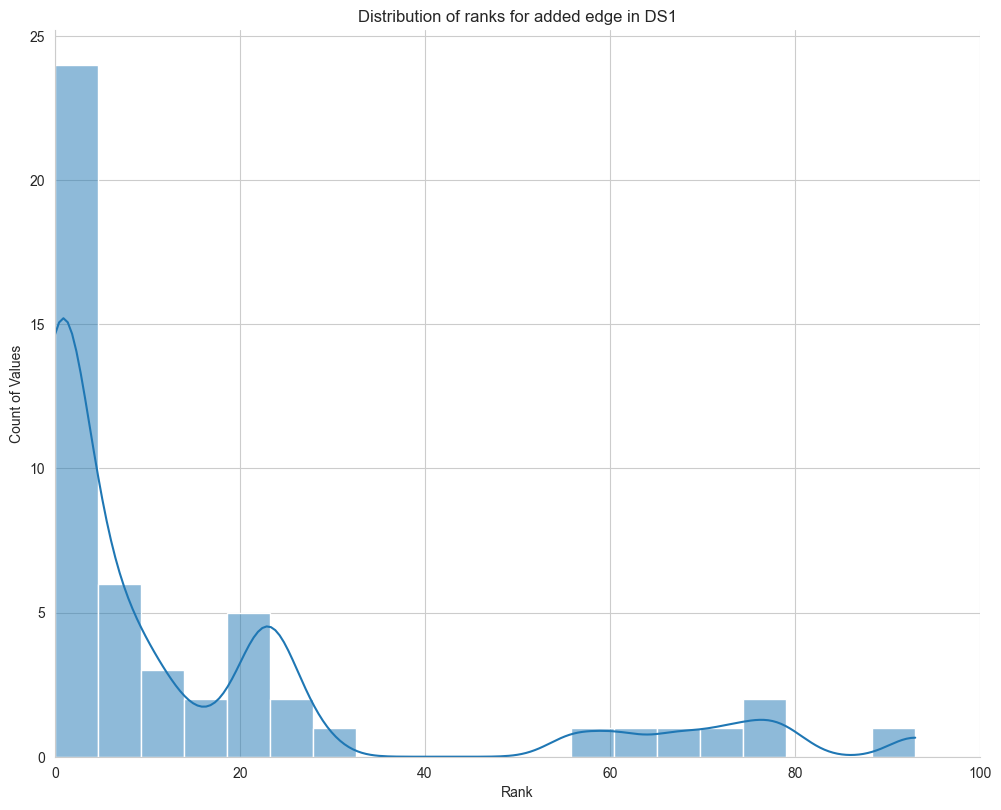

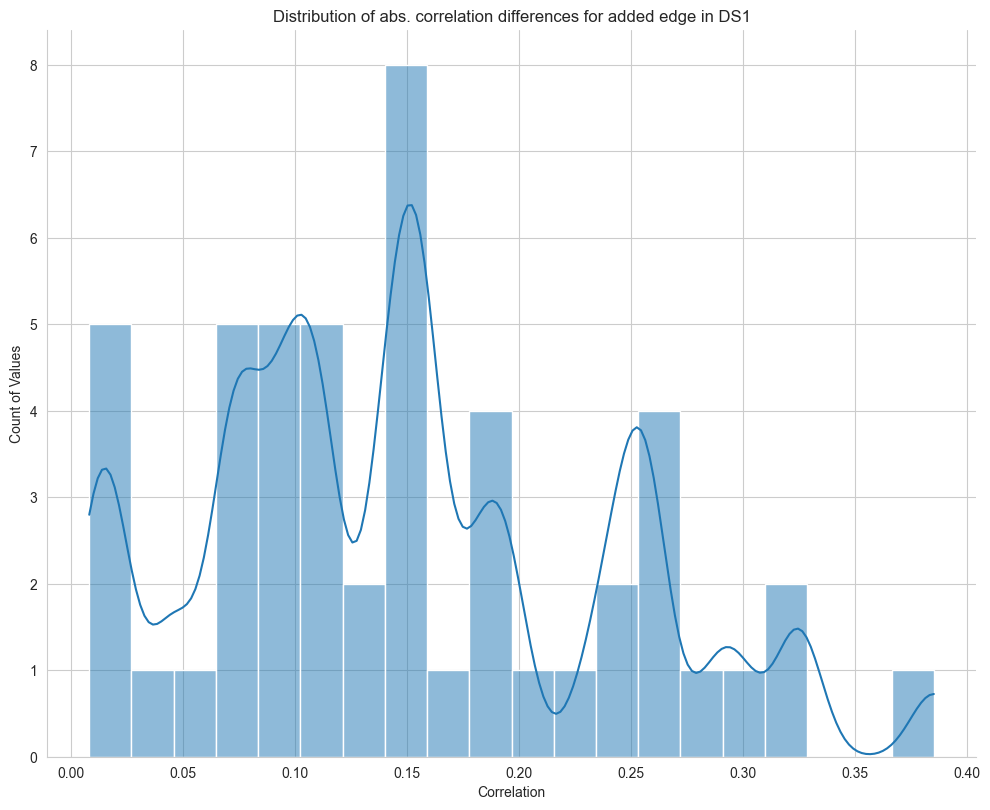

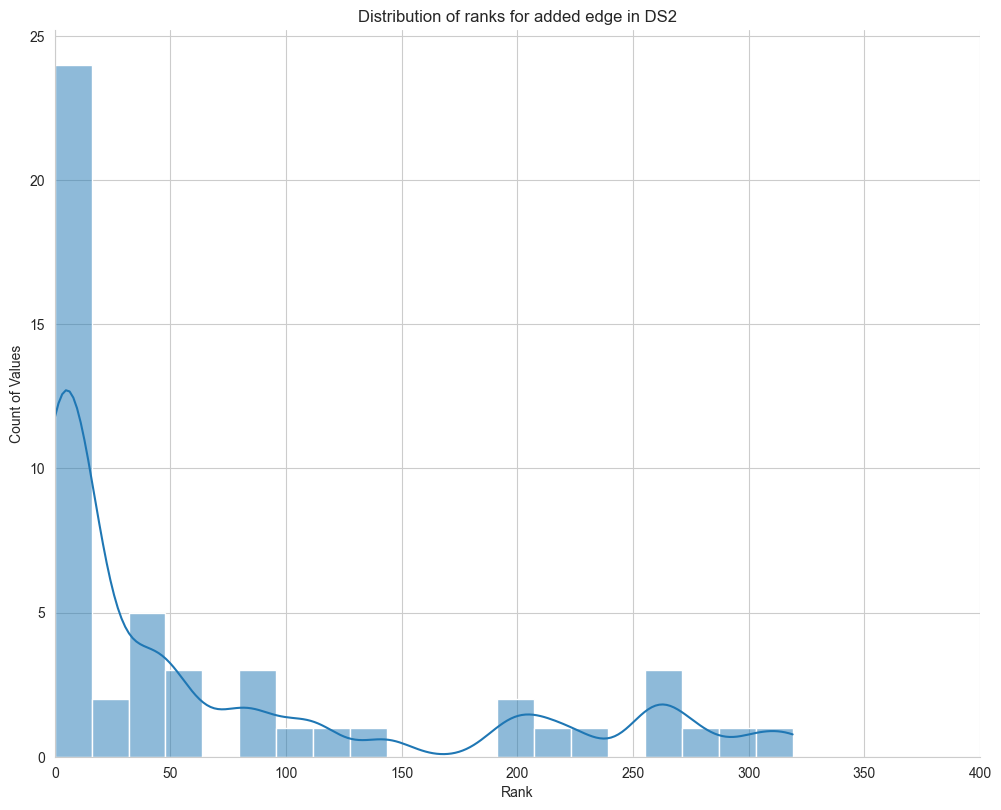

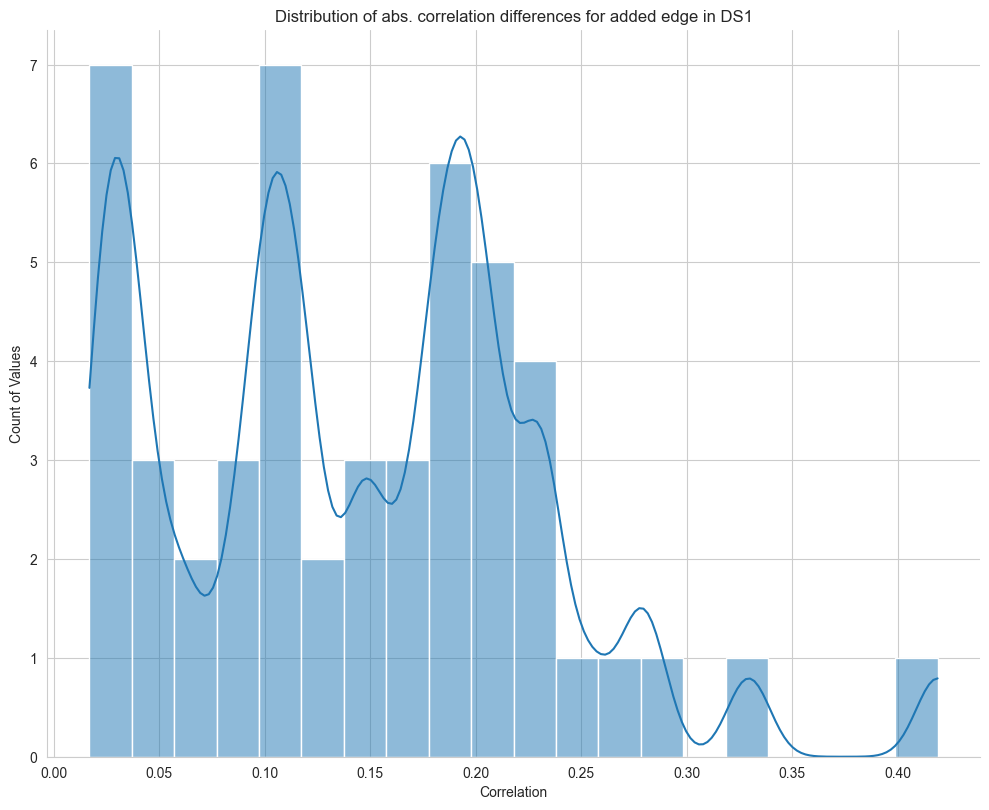

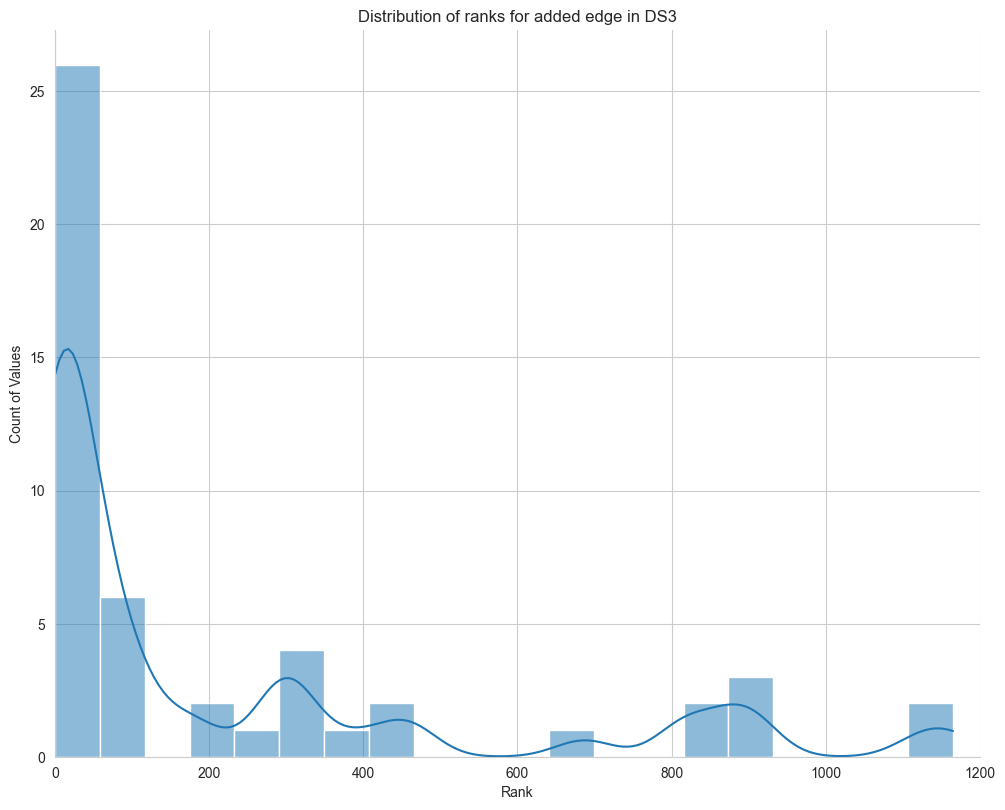

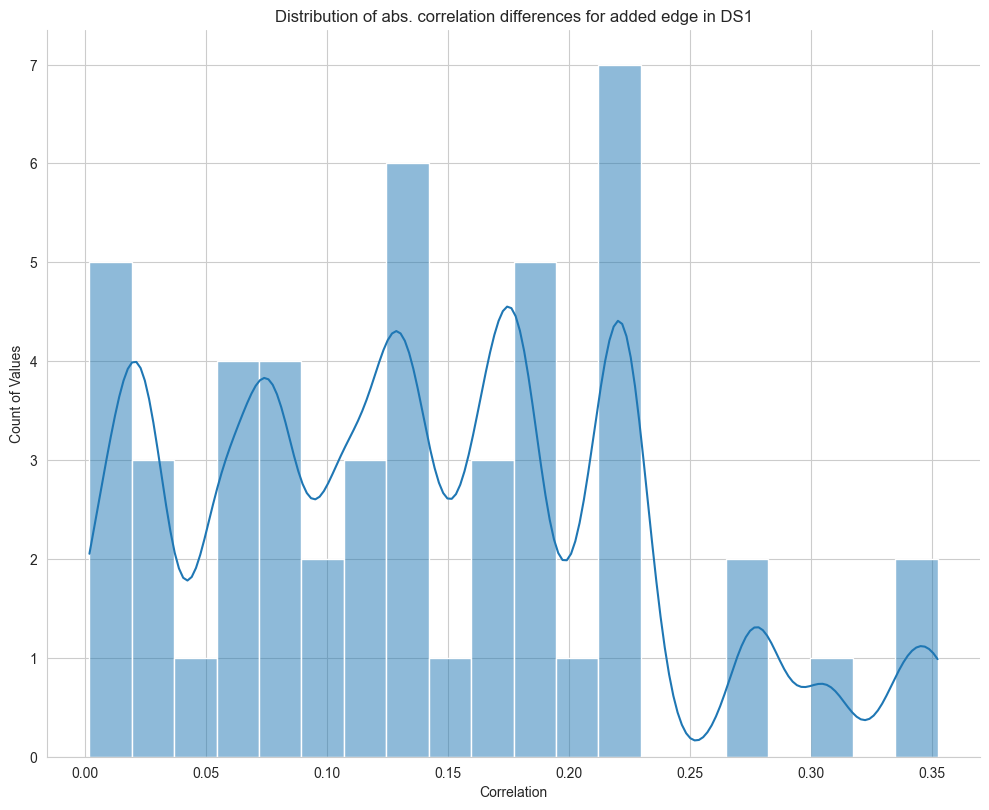

In [23]:
import seaborn as sns
## Plot the results from the experiment
dataset_id = 1
experiment_dir = os.path.join(os.getcwd(), 'experiments/edge_finding/')
for id in range(1, 4):
    experiment_file = os.path.join(experiment_dir, f"DS{id}_edge_finding_experiment.csv")

    load_dir = os.path.join(imp_dir, f'DS{id}')
    save_name = 'DS6_expr.npy'

    expr = np.load(os.path.join(load_dir, save_name))
    lim = expr.shape[1]
    

    df = pd.read_csv(experiment_file)
    sns.set_style("whitegrid")
    # density plot
    plot = sns.displot(df['Rank'], kde=True, bins=20, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
    plot.set(xlim=(0, lim))
    plot.set_axis_labels('Rank', 'Count of Values')
    plt.title(f'Distribution of ranks for added edge in DS{id}')


    plot = sns.displot(df['Correlation'], kde=True, bins=20, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
    #plot.set(xlim=(0, 1))
    plot.set_axis_labels('Correlation', 'Count of Values')
    plt.title(f'Distribution of abs. correlation differences for added edge in DS{dataset_id}')

    print("Means for DS", id, "Rank:", np.mean(df['Rank']), "Correlation:", np.mean(df['Correlation']))
    print("Medians for DS", id, "Rank:", np.median(df['Rank']), "Correlation:", np.median(df['Correlation']))


In [7]:
from scipy.optimize import curve_fit
from scipy.stats import norm

def polynomial_model(x_j, k, n, h):
    numerator = (x_j ** (n + 1))
    denominator = ((x_j ** n) + (h ** n))
    return k * (numerator / denominator)

def fit_poly(x_j, x_i, n, h):
    initial = [1]
    params, _ = curve_fit(lambda x_j, Kij: polynomial_model(x_j, Kij, n, h), x_j, x_i, p0=initial)
    #print(curve_fit(lambda x_j, Kij: polynomial_model(x_j, Kij, n, h), x_j, x_i, p0=initial))
    k_est = params[0]
    return k_est
    #fitted = polynomial_model(x_j, k_est, n, h)
    #error = np.mean(np.abs(fitted - x_i) ** 2)
    #return k_est, error

def calculate_polynomial(x_j, k, h, n):
    numerator = (x_j ** (n))
    denominator = ((x_j ** n) + (h ** n))
    hill = numerator / denominator
    if k < 0:
        return k * (1 - hill)
    else:
        return k * hill
    
def fit_gaussian(row):
    mean, std = norm.fit(row)
    return pd.Series({'mean': mean, 'std': std})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from consolidated_runs import run_simulations

from Pearson.pearson import Pearson

sys.path.append(os.getcwd())

In [5]:
from consolidated_runs import run_sergio
from parallel_utils import new_mean_process_iteration
import random
from time import time
import concurrent
from concurrent.futures import ProcessPoolExecutor

def new_expected_value_experiment(dataset_id, last_iteration=0, fixed_edge=False, add_edge=True):
    #print("Running edge finding experiment")
    gt_file = None
    if dataset_id == 1:
        gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt'
        regs_path = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt'
    elif dataset_id == 2:
        gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Interaction_cID_5.txt'
        regs_path = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Regs_cID_5.txt'
    elif dataset_id == 3:
        gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt'
        regs_path = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt'
        
    reg_df = pd.read_csv(regs_path, header=None)
    master_regs = [int(m) for m in reg_df[0].values]
    true_pearson = pd.DataFrame()
    gt = pd.read_csv(gt_file, header=None)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    load_dir = os.path.join(imp_dir, f'DS{dataset_id}')
    ranks = []
    means = []

    experiment_dir = os.path.join(os.getcwd(), 'experiments/mean_diffs/')
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_mean_diff_experiment.csv")
    if fixed_edge:
        experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_mean_diff_experiment_fixed_edge.csv")
    if os.path.exists(experiment_file) and last_iteration != 0:
        df = pd.read_csv(experiment_file)
        ranks = df['Rank'].values.tolist()
        means = df['Correlation'].values.tolist()

    with ProcessPoolExecutor(max_workers=4) as executor:
        futures = []
        for iteration in range(last_iteration, 51):      
            file_extension = ''                          
            file_extension = f"_iter{iteration}"
            # Get number of genes to choose a target
            if iteration != 0:
                futures.append(executor.submit(new_mean_process_iteration, iteration, target_file, regs_path, master_regs, load_dir, add_edge, imp_dir, dataset_id, file_extension))
        
        iter = 0
        chosen_pairs = []
        chosen_pair_filename = os.path.join(experiment_dir, f"DS{dataset_id}_chosen_pairs.csv")
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            ranks, chosen_pair, rank, temp_target, f_ext = future.result()
            print(chosen_pair, rank)
            experiment_file_ranks = experiment_file.replace('.csv', f'_iter{iter}.csv')
            ranks.to_csv(experiment_file_ranks, index=False)
            chosen_pairs.append(chosen_pair)
            if iter % 10 != 0:
                os.remove(temp_target)
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean{f_ext}.npy"))
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_noisy{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_expr{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean_counts{f_ext}.npy"))
            iter += 1
        chosen_pair_df = pd.DataFrame(chosen_pairs)
        chosen_pair_df.to_csv(chosen_pair_filename, index=False)

In [6]:
new_expected_value_experiment(dataset_id=1, last_iteration=0, fixed_edge=False, add_edge=True)

  0%|          | 0/50 [00:00<?, ?it/s]